In [9]:
import numpy as np
from scipy.stats import norm
import datetime as dt
import matplotlib.pyplot as plt

# Single Barrier Options Analytical Expressions

In [12]:
def C_v(S,K,T,r,q,sigma):
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #q: dividend rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    result = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))        
    return result

def P_v(S,K,T,r,q,sigma):
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #q: dividend rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    result = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))        
    return result

def C_d(S,K,T,r,q,sigma):
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return np.exp(-r*T)*norm.cdf(d2)

def P_d(S,K,T,r,q,sigma):
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return np.exp(-r*T)*norm.cdf(-d2)

#https://people.maths.ox.ac.uk/howison/barriers.pdf

def C_do(S,K,T,r,q,sigma,BL):
    s2 = sigma**2
    k = 2*(r-q)/s2
    a = 0.5*(1-k)
    b = -0.25*(k-1)**2-k
    if BL < K:
        cbs = C_v(S,K,T,r,q,sigma)        
        return  cbs - (S/BL)**(2*a)*C_v(BL**2/S,K,T,r,q,sigma)
    else:
    
        return (C_v(S,BL,T,r,q,sigma) + (BL-K)*C_d(S,BL,T,r,q,sigma) 
               -(S/BL)**(2*a)*(C_v(BL**2/S,BL,T,r,q,sigma) + (BL-K)*C_d(BL**2/S,BL,T,r,q,sigma))
               )

 


def C_di(S,K,T,r,q,sigma,BL):
    s2 = sigma**2
    k = 2*(r-q)/s2
    a = 0.5*(1-k)
    b = -0.25*(k-1)**2-k
    return (S/BL)**(2*a)*C_v(BL**2/S,K,T,r,q,sigma)


def P_do(S,K,T,r,q,sigma,BL):
    s2 = sigma**2
    k = 2*(r-q)/s2
    a = 0.5*(1-k)
    b = -0.25*(k-1)**2-k

    return (P_v(S,K,T,r,q,sigma) - P_v(S,BL,T,r,q,sigma)  - (K-BL)*P_d(S,BL,T,r,q,sigma) 
            - (S/BL)**2 * (P_v(BL**2/S,K,T,r,q,sigma) - P_v(BL**2/S,BL,T,r,q,sigma) - (K-BL)*P_d(BL**2/S,BL,T,r,q,sigma) )
            )

def C_uo(S,K,T,r,q,sigma,BL):
    s2 = sigma**2
    k = 2*(r-q)/s2
    a = 0.5*(1-k)
    b = -0.25*(k-1)**2-k

    npv = (C_v(S,K,T,r,q,sigma) - C_v(S,BL,T,r,q,sigma)  - (BL-K)*C_d(S,BL,T,r,q,sigma) 
            - (S/BL)**2 * (C_v(BL**2/S,K,T,r,q,sigma) - C_v(BL**2/S,BL,T,r,q,sigma) - (BL-K)*C_d(BL**2/S,BL,T,r,q,sigma) )
            )
    return npv

def P_uo(S,K,T,r,q,sigma,BL):
    s2 = sigma**2
    k = 2*(r-q)/s2
    a = 0.5*(1-k)
    b = -0.25*(k-1)**2-k
    npv = (P_v(S,BL,T,r,q,sigma) + (K-BL)*P_d(S,BL,T,r,q,sigma) 
               -(S/BL)**(2*a)*(P_v(BL**2/S,BL,T,r,q,sigma) + (K-BL)*P_d(BL**2/S,BL,T,r,q,sigma))
            )
    return npv



def syntheticStock(S,K,T,r,q,sigma,BL,gearing):
    return C_uo(S,K,T,r,q,sigma,BL) - gearing * P_uo(S,K,T,r,q,sigma,BL)



def accumulator(S,K,r,q,sigma,BL,gearing,periods,shares_per_day,cob):
    payoff = 0
    for x in periods:
        (dstart,dend) = x
        if dend > cob:
            ndays = np.busday_count( dstart, dend )
            T = np.busday_count( cob, dend )/260.0
            payoff += ndays * shares_per_day * syntheticStock(S,K,T,r,q,sigma,BL,gearing)
    return payoff


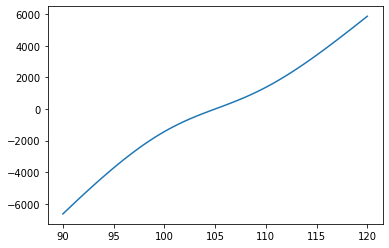

In [15]:
cob = dt.date(2021,9,25)
BL=105
K=100
gearing=1
shares_per_day = 10
r=0.01
q=0.0
sigma = 0.2
period_starts = [cob + dt.timedelta(days=20*i) for i in range(0,5)]
periods_ends = [t0 + dt.timedelta(days=19) for t0 in period_starts]
periods = list(zip(period_starts,periods_ends))


npv = lambda s : accumulator(s,K,r,q,sigma,BL,gearing,periods,shares_per_day,cob)
Ss = np.linspace(90,120,100)
npvs =[]
for s in Ss:
    aux = npv(s)

    npvs.append(aux)
plt.plot(Ss,npvs)
plt.show()